In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt 

DATA_NAME = 'binary_random_20fa.hdf5'

In [2]:
with h5py.File(DATA_NAME, 'r') as hf:
    print(list(hf.keys()))
    human=hf['human'][:]
    machine=hf['machine'][:]
    print(human.shape)
    print(machine.shape)
    print(human[0])
    print(machine[0])

['human', 'machine']
(5100, 20)
(5100, 20)
[ 1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.
  1.  1.]
[ 1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1 -1  1]


In [3]:
x = np.vstack(( human, machine))
y = np.append( np.ones(np.shape(human)[0]), np.zeros(np.shape(machine)[0]))
y = np.reshape(y,(y.shape[0],1))
dataset = np.concatenate((x, y), axis=1)
np.random.shuffle(dataset)

In [4]:
split_ratio=0.8 #80-20 train/validation split 
length_train=int(split_ratio*len(dataset)) #number of training samples 

trainset=dataset[0:length_train]
valset=dataset[length_train:]

In [5]:
print(trainset.shape)
print(valset.shape)
print(trainset[0])

(8160, 21)
(2040, 21)
[-1.  1.  1. -1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.
 -1. -1.  1.]


In [6]:
#torch,torchvision, torchvision transforms
import torch
import torch.nn as nn
import torch.nn.functional as F #useful library for operations like relu 
import torch.optim as optim
import torchvision

In [7]:
#Declaring the network architecture 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()  #declare all layers
        self.linear_1=nn.Linear(20,20) #input_dimensions x output_dimensions
        self.dropout=nn.Dropout(p=0.2)
        self.output=nn.Linear(20,1)
    def forward(self,x):
        x=self.linear_1(x) #passing through linear layer (784*128)
        x=F.relu(x) #passing through relu activation
        x=self.dropout(x)
        x=self.output(x)
        return(x)

In [8]:
net=Net()

In [9]:
device = torch.device('cpu')
print(device)
net=net.to(device)

cpu


In [10]:
criterion=nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
def eval_model(model,loader,criterion):
    """model: instance of model class 
       loader: test dataloader
       criterion: loss function
       device: CPU/GPU
    """
    model.eval() #needed to run the model in eval mode to freeze all the layers
    correct=0
    total=0
    total_loss=0
    with torch.no_grad():
        total=0
        correct=0
        for j in range(loader.shape[0]):
            inputs=loader[:,:-1]
            labels=loader[:,-1]
            inputs =torch.from_numpy(inputs).reshape(loader.shape[0],20).float()
            labels =torch.from_numpy(labels).reshape(loader.shape[0],1).float()
            outputs=model(inputs)
            outputs=torch.sigmoid(outputs)
            val_loss=criterion(outputs,labels)
            total_loss=total_loss+val_loss
            preds=np.where(outputs > 0.5, 1, 0)
            preds=torch.from_numpy(preds).float()            
            correct=correct+(preds==labels).cpu().sum().numpy() 
            total=total+len(labels)
    Accuracy=100*(correct/total)
    fin_loss=total_loss/(len(loader))
    
    return(Accuracy,fin_loss)

In [12]:
num_epochs=20
batch_size=16
train_loss_list=[]
train_acc_list=[]
val_loss_list=[]
val_acc_list=[]

#TRAINING LOOP
for i in np.arange(num_epochs): #outer loop 
    train_loss=0.0
    correct=0
    for j in range(trainset.shape[0]//batch_size): 
        
        inputs=trainset[j*batch_size:(j+1)*batch_size,:-1]
        labels=trainset[j*batch_size:(j+1)*batch_size,-1]
        inputs =torch.from_numpy(inputs).reshape(batch_size,20).float()
        labels =torch.from_numpy(labels).reshape(batch_size,1).float()
        
        l2_regularization=torch.tensor(0).float()
        
        #zero out the gradients to avoid any accumulation during backprop
        optimizer.zero_grad()
        #forward pass through the network
        outputs = net(inputs) #batch_size x 10
        outputs = torch.sigmoid(outputs)        
        for param in net.parameters():
            l2_regularization += torch.norm(param,2)**2
            

        loss=criterion(outputs,labels)+0.001*l2_regularization

        loss.backward() #computes derivative of loss for every variable (gradients)
        optimizer.step() #optimizer updates based on gradients 
        
        preds=np.where(outputs > 0.5, 1, 0)
        preds=torch.from_numpy(preds).float()
        correct=correct+(preds==labels).cpu().sum().numpy() 
        train_loss=train_loss+loss.item()
    
    
    val_accuracy,val_loss=eval_model(net,valset,criterion)
    train_loss=train_loss/(trainset.shape[0]//batch_size) #computing the total loss for the entire training set
    train_accuracy=100*(correct/trainset.shape[0]) #train accuracy for the dataset
    
    print('Epoch:%d,Train Loss:%f,Training Accuracy:%f,Validation Loss:%f,Validation Accuracy:%f'%(i+1,train_loss,train_accuracy,val_loss,val_accuracy))
    
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_accuracy)

Epoch:1,Train Loss:0.700756,Training Accuracy:51.200980,Validation Loss:0.684945,Validation Accuracy:56.568627
Epoch:2,Train Loss:0.687273,Training Accuracy:56.433824,Validation Loss:0.676593,Validation Accuracy:57.107843
Epoch:3,Train Loss:0.677847,Training Accuracy:58.468137,Validation Loss:0.670155,Validation Accuracy:57.205882
Epoch:4,Train Loss:0.671255,Training Accuracy:59.191176,Validation Loss:0.665660,Validation Accuracy:58.088235
Epoch:5,Train Loss:0.666871,Training Accuracy:59.558824,Validation Loss:0.662966,Validation Accuracy:58.333333
Epoch:6,Train Loss:0.663857,Training Accuracy:60.379902,Validation Loss:0.661022,Validation Accuracy:58.431373
Epoch:7,Train Loss:0.661512,Training Accuracy:60.870098,Validation Loss:0.660080,Validation Accuracy:58.480392
Epoch:8,Train Loss:0.659672,Training Accuracy:61.188725,Validation Loss:0.659180,Validation Accuracy:58.627451
Epoch:9,Train Loss:0.658079,Training Accuracy:61.274510,Validation Loss:0.658683,Validation Accuracy:58.627451
E

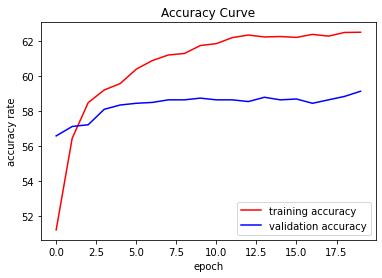

In [13]:
plt.figure()
plt.title('Accuracy Curve')
plt.xlabel('epoch')
plt.ylabel('accuracy rate')
plt.plot(train_acc_list,c='r',label='training accuracy')
plt.plot(val_acc_list,c='b',label='validation accuracy')
plt.legend()
plt.show()

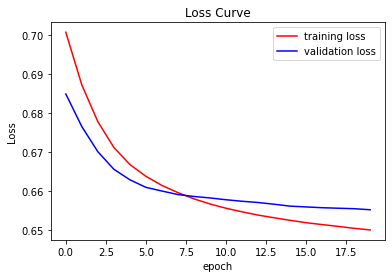

In [14]:
plt.title('Loss Curve')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.plot(train_loss_list,c='r',label='training loss')
plt.plot(val_loss_list,c='b',label='validation loss')
plt.legend()
plt.show()

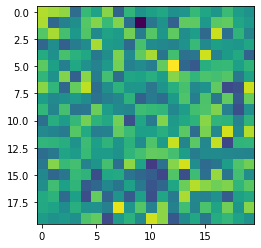

In [15]:
train_para_output_W = net.linear_1.weight.detach()
plt.figure()
plt.imshow(train_para_output_W, interpolation='nearest')
plt.show()